# Smoker Status
[Kaggle Competiton](https://www.kaggle.com/competitions/playground-series-s3e24/)


age : 5-years gap
height(cm)
weight(kg)
waist(cm) : Waist circumference length
eyesight(left)
eyesight(right)
hearing(left)
hearing(right)
systolic : Blood pressure
relaxation : Blood pressure
fasting blood sugar
Cholesterol : total
triglyceride
HDL : cholesterol type
LDL : cholesterol type
hemoglobin
Urine protein
serum creatinine
AST : glutamic oxaloacetic transaminase type
ALT : glutamic oxaloacetic transaminase type
Gtp : γ-GTP
dental caries
smoking

In [3]:
import pandas as pd
mnist_train = pd.read_csv("/home/rainer/Downloads/ML_datasets/smokerstatus_train.csv")
mnist_train

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,159251,40,155,45,69.0,1.5,2.0,1,1,127,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,159252,50,155,75,82.0,1.0,1.0,1,1,120,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,159253,40,160,50,66.0,1.5,1.0,1,1,114,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,159254,50,165,75,92.0,1.2,1.0,1,1,121,...,55,80,14.4,1,1.1,22,17,37,0,1


In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import optuna
from sklearn.metrics import accuracy_score


def convert(dataframe):
    dataframe.set_index("id", inplace=True)
    return dataframe


mnist_train = pd.read_csv("/home/rainer/Downloads/ML_datasets/smokerstatus_train.csv")
mnist_train = convert(mnist_train)
mnist_train["smoking"] =mnist_train["smoking"].astype(bool)

X, Y = mnist_train.drop('smoking', axis=1), mnist_train[['smoking']]
dtrain = xgb.DMatrix(X, Y, enable_categorical=False)

In [2]:
boostrounds=100

def objective(trial):
    param = {
        'tree_method':'gpu_hist',
        "objective": "binary:logistic", #https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters
        'eta': trial.suggest_float('eta', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1),
    }


    results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=boostrounds,
        nfold=5,
        early_stopping_rounds=50,
        verbose_eval=100, # print eval every xth round
        metrics=["rmse", "mae", "auc"], #see "eval_metric"
    )

    return results.iloc[-1]["test-auc-mean"]

In [3]:
study = optuna.create_study(direction='maximize') # watch out! AUC needs to be maximized
study.optimize(objective, n_trials=100)
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-11-13 22:46:20,401] A new study created in memory with name: no-name-ec583020-9caa-4cec-b4a9-d478bbb69604


[0]	train-rmse:0.43922+0.00035	train-mae:0.42523+0.00054	train-auc:0.80757+0.00061	test-rmse:0.43938+0.00042	test-mae:0.42538+0.00034	test-auc:0.80704+0.00192
[99]	train-rmse:0.38277+0.00047	train-mae:0.28877+0.00102	train-auc:0.86598+0.00058	test-rmse:0.38913+0.00136	test-mae:0.29368+0.00085	test-auc:0.85705+0.00186


[I 2023-11-13 22:46:23,934] Trial 0 finished with value: 0.8570454100191238 and parameters: {'eta': 0.49516789299507064, 'max_depth': 3, 'min_child_weight': 0.05986766276876473, 'subsample': 0.2099573917763468, 'colsample_bynode': 0.9110279454148953}. Best is trial 0 with value: 0.8570454100191238.


[0]	train-rmse:0.47235+0.00010	train-mae:0.47071+0.00011	train-auc:0.83627+0.00046	test-rmse:0.47281+0.00029	test-mae:0.47114+0.00029	test-auc:0.83078+0.00291
[99]	train-rmse:0.36131+0.00058	train-mae:0.27136+0.00076	train-auc:0.89468+0.00068	test-rmse:0.38735+0.00119	test-mae:0.29139+0.00108	test-auc:0.85962+0.00164


[I 2023-11-13 22:46:30,315] Trial 1 finished with value: 0.8596217235385278 and parameters: {'eta': 0.15967682772346295, 'max_depth': 9, 'min_child_weight': 6.665204431005287, 'subsample': 0.24868913660144393, 'colsample_bynode': 0.374088350252054}. Best is trial 1 with value: 0.8596217235385278.


[0]	train-rmse:0.45751+0.00022	train-mae:0.45168+0.00026	train-auc:0.79804+0.00089	test-rmse:0.45757+0.00057	test-mae:0.45173+0.00062	test-auc:0.79777+0.00312
[99]	train-rmse:0.38143+0.00046	train-mae:0.29249+0.00095	train-auc:0.86774+0.00048	test-rmse:0.38551+0.00130	test-mae:0.29568+0.00085	test-auc:0.86173+0.00186


[I 2023-11-13 22:46:32,692] Trial 2 finished with value: 0.8617259840402742 and parameters: {'eta': 0.3220641746776041, 'max_depth': 3, 'min_child_weight': 2.352819314428119, 'subsample': 0.3115214672101828, 'colsample_bynode': 0.6202832843744132}. Best is trial 2 with value: 0.8617259840402742.


[0]	train-rmse:0.46407+0.00012	train-mae:0.46141+0.00013	train-auc:0.84620+0.00067	test-rmse:0.46608+0.00035	test-mae:0.46328+0.00035	test-auc:0.82922+0.00277
[80]	train-rmse:0.30571+0.00106	train-mae:0.22098+0.00086	train-auc:0.95073+0.00087	test-rmse:0.39193+0.00083	test-mae:0.28673+0.00100	test-auc:0.85503+0.00135


[I 2023-11-13 22:46:42,953] Trial 3 finished with value: 0.8574578117844458 and parameters: {'eta': 0.1991782319111326, 'max_depth': 10, 'min_child_weight': 0.010051894838983768, 'subsample': 0.4316646601502544, 'colsample_bynode': 0.5286887656581554}. Best is trial 2 with value: 0.8617259840402742.


[0]	train-rmse:0.47936+0.00008	train-mae:0.47845+0.00008	train-auc:0.82892+0.00049	test-rmse:0.47950+0.00018	test-mae:0.47859+0.00017	test-auc:0.82714+0.00277
[99]	train-rmse:0.37327+0.00054	train-mae:0.28625+0.00088	train-auc:0.87945+0.00068	test-rmse:0.38432+0.00137	test-mae:0.29477+0.00127	test-auc:0.86350+0.00189


[I 2023-11-13 22:46:46,611] Trial 4 finished with value: 0.8635048541168565 and parameters: {'eta': 0.12264903405242718, 'max_depth': 6, 'min_child_weight': 1.0129820151549667, 'subsample': 0.27473495213855015, 'colsample_bynode': 0.6686100101584475}. Best is trial 4 with value: 0.8635048541168565.


[0]	train-rmse:0.45811+0.00020	train-mae:0.45359+0.00023	train-auc:0.82604+0.00083	test-rmse:0.45831+0.00032	test-mae:0.45378+0.00031	test-auc:0.82473+0.00202
[99]	train-rmse:0.37300+0.00016	train-mae:0.28074+0.00049	train-auc:0.87948+0.00023	test-rmse:0.38764+0.00130	test-mae:0.29206+0.00100	test-auc:0.85898+0.00168


[I 2023-11-13 22:46:49,440] Trial 5 finished with value: 0.8589834136160244 and parameters: {'eta': 0.2709986345089326, 'max_depth': 5, 'min_child_weight': 0.2035030655276118, 'subsample': 0.2535736479498545, 'colsample_bynode': 0.9904867368584105}. Best is trial 4 with value: 0.8635048541168565.


[0]	train-rmse:0.44545+0.00026	train-mae:0.43765+0.00028	train-auc:0.83639+0.00104	test-rmse:0.44701+0.00054	test-mae:0.43904+0.00057	test-auc:0.82838+0.00212
[75]	train-rmse:0.33225+0.00110	train-mae:0.24307+0.00105	train-auc:0.92663+0.00112	test-rmse:0.39080+0.00075	test-mae:0.28795+0.00115	test-auc:0.85610+0.00097


[I 2023-11-13 22:46:53,859] Trial 6 finished with value: 0.8588453080641653 and parameters: {'eta': 0.3543672193686093, 'max_depth': 8, 'min_child_weight': 0.1065900653653101, 'subsample': 0.6599406699130076, 'colsample_bynode': 0.28092426079314503}. Best is trial 4 with value: 0.8635048541168565.


[0]	train-rmse:0.42861+0.00027	train-mae:0.41317+0.00033	train-auc:0.84050+0.00048	test-rmse:0.43080+0.00062	test-mae:0.41506+0.00063	test-auc:0.83330+0.00174
[61]	train-rmse:0.33346+0.00143	train-mae:0.23317+0.00147	train-auc:0.92301+0.00130	test-rmse:0.40478+0.00163	test-mae:0.28762+0.00181	test-auc:0.84216+0.00222


[I 2023-11-13 22:46:57,495] Trial 7 finished with value: 0.8530065715164799 and parameters: {'eta': 0.4898116963891225, 'max_depth': 8, 'min_child_weight': 0.34625847136495885, 'subsample': 0.455884450738942, 'colsample_bynode': 0.7158783485777226}. Best is trial 4 with value: 0.8635048541168565.


[0]	train-rmse:0.49180+0.00006	train-mae:0.49165+0.00006	train-auc:0.81235+0.00134	test-rmse:0.49194+0.00008	test-mae:0.49179+0.00008	test-auc:0.80636+0.00208
[99]	train-rmse:0.37618+0.00032	train-mae:0.30261+0.00028	train-auc:0.87807+0.00053	test-rmse:0.38686+0.00114	test-mae:0.31120+0.00152	test-auc:0.86081+0.00169


[I 2023-11-13 22:47:03,362] Trial 8 finished with value: 0.860805513322051 and parameters: {'eta': 0.05222874287203939, 'max_depth': 8, 'min_child_weight': 0.29062343817593456, 'subsample': 0.8066383414889202, 'colsample_bynode': 0.1257857553590335}. Best is trial 4 with value: 0.8635048541168565.


[0]	train-rmse:0.46552+0.00016	train-mae:0.46325+0.00016	train-auc:0.85210+0.00100	test-rmse:0.46766+0.00037	test-mae:0.46525+0.00037	test-auc:0.83246+0.00249
[99]	train-rmse:0.30138+0.00111	train-mae:0.22291+0.00071	train-auc:0.95713+0.00105	test-rmse:0.38540+0.00129	test-mae:0.28628+0.00131	test-auc:0.86262+0.00181


[I 2023-11-13 22:47:13,057] Trial 9 finished with value: 0.8626196127355786 and parameters: {'eta': 0.19158325573343904, 'max_depth': 10, 'min_child_weight': 1.4578225944875651, 'subsample': 0.9305772563804278, 'colsample_bynode': 0.31318284079476666}. Best is trial 4 with value: 0.8635048541168565.


[0]	train-rmse:0.49737+0.00002	train-mae:0.49736+0.00002	train-auc:0.82569+0.00101	test-rmse:0.49738+0.00001	test-mae:0.49737+0.00001	test-auc:0.82442+0.00214
[99]	train-rmse:0.39924+0.00031	train-mae:0.35737+0.00033	train-auc:0.85528+0.00062	test-rmse:0.40058+0.00093	test-mae:0.35847+0.00114	test-auc:0.85218+0.00186


[I 2023-11-13 22:47:16,496] Trial 10 finished with value: 0.8521812816459153 and parameters: {'eta': 0.015081090683602777, 'max_depth': 6, 'min_child_weight': 8.959286469991097, 'subsample': 0.11305672348087567, 'colsample_bynode': 0.8006197241406092}. Best is trial 4 with value: 0.8635048541168565.


[0]	train-rmse:0.48051+0.00008	train-mae:0.47967+0.00008	train-auc:0.82103+0.00072	test-rmse:0.48061+0.00021	test-mae:0.47976+0.00021	test-auc:0.81969+0.00294
[99]	train-rmse:0.37711+0.00031	train-mae:0.29332+0.00048	train-auc:0.87440+0.00042	test-rmse:0.38379+0.00138	test-mae:0.29853+0.00135	test-auc:0.86438+0.00206


[I 2023-11-13 22:47:19,243] Trial 11 finished with value: 0.8643782838283821 and parameters: {'eta': 0.12093401411228254, 'max_depth': 5, 'min_child_weight': 1.2125961245262977, 'subsample': 0.9672514626690925, 'colsample_bynode': 0.48018197996705037}. Best is trial 11 with value: 0.8643782838283821.


[0]	train-rmse:0.48415+0.00005	train-mae:0.48360+0.00005	train-auc:0.82162+0.00050	test-rmse:0.48421+0.00013	test-mae:0.48366+0.00014	test-auc:0.82023+0.00276
[99]	train-rmse:0.37872+0.00034	train-mae:0.29622+0.00052	train-auc:0.87228+0.00051	test-rmse:0.38432+0.00142	test-mae:0.30062+0.00129	test-auc:0.86378+0.00211


[I 2023-11-13 22:47:22,035] Trial 12 finished with value: 0.8637767027165136 and parameters: {'eta': 0.09728575714346407, 'max_depth': 5, 'min_child_weight': 1.0542131736302387, 'subsample': 0.9820490448191396, 'colsample_bynode': 0.5245080829676007}. Best is trial 11 with value: 0.8643782838283821.


[0]	train-rmse:0.48837+0.00005	train-mae:0.48807+0.00005	train-auc:0.81386+0.00073	test-rmse:0.48840+0.00012	test-mae:0.48809+0.00012	test-auc:0.81340+0.00269
[99]	train-rmse:0.38516+0.00039	train-mae:0.30766+0.00059	train-auc:0.86340+0.00060	test-rmse:0.38739+0.00127	test-mae:0.30944+0.00138	test-auc:0.85977+0.00201


[I 2023-11-13 22:47:24,352] Trial 13 finished with value: 0.8597683290646566 and parameters: {'eta': 0.07345200947497244, 'max_depth': 4, 'min_child_weight': 0.8581387996983246, 'subsample': 0.9729306563010693, 'colsample_bynode': 0.4861293522775995}. Best is trial 11 with value: 0.8643782838283821.


[0]	train-rmse:0.48322+0.00007	train-mae:0.48260+0.00007	train-auc:0.82126+0.00065	test-rmse:0.48330+0.00018	test-mae:0.48268+0.00018	test-auc:0.81975+0.00302
[99]	train-rmse:0.37848+0.00030	train-mae:0.29563+0.00050	train-auc:0.87255+0.00039	test-rmse:0.38420+0.00137	test-mae:0.30014+0.00137	test-auc:0.86386+0.00207


[I 2023-11-13 22:47:27,102] Trial 14 finished with value: 0.8638555489614406 and parameters: {'eta': 0.10335920831602241, 'max_depth': 5, 'min_child_weight': 3.0674322675876455, 'subsample': 0.9964633030837118, 'colsample_bynode': 0.47733627995224176}. Best is trial 11 with value: 0.8643782838283821.


[0]	train-rmse:0.49813+0.00001	train-mae:0.49812+0.00001	train-auc:0.82118+0.00069	test-rmse:0.49814+0.00002	test-mae:0.49813+0.00002	test-auc:0.82003+0.00301
[99]	train-rmse:0.41211+0.00025	train-mae:0.38386+0.00032	train-auc:0.84665+0.00057	test-rmse:0.41289+0.00082	test-mae:0.38453+0.00094	test-auc:0.84453+0.00210


[I 2023-11-13 22:47:29,813] Trial 15 finished with value: 0.8445345147600534 and parameters: {'eta': 0.01114757389420884, 'max_depth': 5, 'min_child_weight': 3.7717182505737545, 'subsample': 0.8157848831727028, 'colsample_bynode': 0.4115688823531998}. Best is trial 11 with value: 0.8643782838283821.


[0]	train-rmse:0.47692+0.00007	train-mae:0.47584+0.00007	train-auc:0.83714+0.00065	test-rmse:0.47724+0.00019	test-mae:0.47615+0.00020	test-auc:0.83284+0.00202
[99]	train-rmse:0.36232+0.00055	train-mae:0.27752+0.00063	train-auc:0.89437+0.00066	test-rmse:0.38305+0.00137	test-mae:0.29347+0.00144	test-auc:0.86535+0.00187


[I 2023-11-13 22:47:33,977] Trial 16 finished with value: 0.8653477657505272 and parameters: {'eta': 0.13410870638836206, 'max_depth': 7, 'min_child_weight': 3.7936123097262784, 'subsample': 0.8430684942598732, 'colsample_bynode': 0.5890278958445101}. Best is trial 16 with value: 0.8653477657505272.


[0]	train-rmse:0.47530+0.00009	train-mae:0.47404+0.00009	train-auc:0.83661+0.00062	test-rmse:0.47561+0.00023	test-mae:0.47434+0.00024	test-auc:0.83272+0.00247
[99]	train-rmse:0.36235+0.00017	train-mae:0.27675+0.00034	train-auc:0.89436+0.00023	test-rmse:0.38290+0.00149	test-mae:0.29263+0.00153	test-auc:0.86550+0.00213


[I 2023-11-13 22:47:38,098] Trial 17 finished with value: 0.8655040699522172 and parameters: {'eta': 0.14440093885109134, 'max_depth': 7, 'min_child_weight': 5.570466104805208, 'subsample': 0.7076549055990085, 'colsample_bynode': 0.6252977851851313}. Best is trial 17 with value: 0.8655040699522172.


[0]	train-rmse:0.46559+0.00011	train-mae:0.46297+0.00012	train-auc:0.83617+0.00054	test-rmse:0.46600+0.00030	test-mae:0.46335+0.00030	test-auc:0.83285+0.00250
[99]	train-rmse:0.35868+0.00058	train-mae:0.27132+0.00056	train-auc:0.89863+0.00072	test-rmse:0.38332+0.00125	test-mae:0.29022+0.00120	test-auc:0.86504+0.00165


[I 2023-11-13 22:47:41,990] Trial 18 finished with value: 0.8650353797892469 and parameters: {'eta': 0.20714399199441158, 'max_depth': 7, 'min_child_weight': 8.067751459214833, 'subsample': 0.6410782356769517, 'colsample_bynode': 0.6154806299516697}. Best is trial 17 with value: 0.8655040699522172.


[0]	train-rmse:0.47643+0.00009	train-mae:0.47531+0.00009	train-auc:0.83816+0.00048	test-rmse:0.47679+0.00017	test-mae:0.47565+0.00016	test-auc:0.83344+0.00224
[99]	train-rmse:0.36130+0.00057	train-mae:0.27608+0.00069	train-auc:0.89568+0.00070	test-rmse:0.38277+0.00150	test-mae:0.29258+0.00144	test-auc:0.86581+0.00220


[I 2023-11-13 22:47:46,184] Trial 19 finished with value: 0.8658129338280272 and parameters: {'eta': 0.13609466909186957, 'max_depth': 7, 'min_child_weight': 4.06586388440552, 'subsample': 0.7360437340888273, 'colsample_bynode': 0.8037820660765835}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.47080+0.00009	train-mae:0.46900+0.00009	train-auc:0.83714+0.00058	test-rmse:0.47124+0.00022	test-mae:0.46942+0.00022	test-auc:0.83267+0.00194
[99]	train-rmse:0.35834+0.00058	train-mae:0.27226+0.00072	train-auc:0.89931+0.00065	test-rmse:0.38296+0.00147	test-mae:0.29118+0.00143	test-auc:0.86547+0.00213


[I 2023-11-13 22:47:50,088] Trial 20 finished with value: 0.8654663650915989 and parameters: {'eta': 0.17177768523584222, 'max_depth': 7, 'min_child_weight': 5.17125473374437, 'subsample': 0.6884069889777664, 'colsample_bynode': 0.7823576916662928}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.47150+0.00013	train-mae:0.46980+0.00013	train-auc:0.83711+0.00084	test-rmse:0.47189+0.00019	test-mae:0.47016+0.00019	test-auc:0.83307+0.00186
[99]	train-rmse:0.36156+0.00048	train-mae:0.27522+0.00054	train-auc:0.89523+0.00067	test-rmse:0.38294+0.00151	test-mae:0.29167+0.00144	test-auc:0.86550+0.00211


[I 2023-11-13 22:47:54,042] Trial 21 finished with value: 0.8655034822077127 and parameters: {'eta': 0.16747555571444123, 'max_depth': 7, 'min_child_weight': 9.962103020748861, 'subsample': 0.6886818516004793, 'colsample_bynode': 0.7749024963363055}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.46075+0.00014	train-mae:0.45752+0.00014	train-auc:0.84647+0.00053	test-rmse:0.46201+0.00033	test-mae:0.45869+0.00032	test-auc:0.83678+0.00258
[99]	train-rmse:0.33327+0.00075	train-mae:0.24789+0.00081	train-auc:0.92741+0.00077	test-rmse:0.38496+0.00115	test-mae:0.28682+0.00133	test-auc:0.86330+0.00155


[I 2023-11-13 22:47:59,950] Trial 22 finished with value: 0.8633027291671486 and parameters: {'eta': 0.2269365628552808, 'max_depth': 9, 'min_child_weight': 9.661639386068751, 'subsample': 0.7285080486499951, 'colsample_bynode': 0.7461987987957583}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.47701+0.00007	train-mae:0.47591+0.00007	train-auc:0.83344+0.00066	test-rmse:0.47720+0.00015	test-mae:0.47609+0.00015	test-auc:0.83112+0.00196
[99]	train-rmse:0.37054+0.00022	train-mae:0.28447+0.00039	train-auc:0.88338+0.00028	test-rmse:0.38321+0.00124	test-mae:0.29422+0.00138	test-auc:0.86513+0.00192


[I 2023-11-13 22:48:03,251] Trial 23 finished with value: 0.8651263689090657 and parameters: {'eta': 0.1355509120355556, 'max_depth': 6, 'min_child_weight': 5.109435920052395, 'subsample': 0.5890837456630132, 'colsample_bynode': 0.8540259928050546}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.47320+0.00014	train-mae:0.47170+0.00015	train-auc:0.83628+0.00079	test-rmse:0.47359+0.00020	test-mae:0.47206+0.00020	test-auc:0.83185+0.00204
[99]	train-rmse:0.35951+0.00063	train-mae:0.27326+0.00074	train-auc:0.89774+0.00075	test-rmse:0.38347+0.00112	test-mae:0.29157+0.00115	test-auc:0.86478+0.00155


[I 2023-11-13 22:48:07,378] Trial 24 finished with value: 0.8647789063989118 and parameters: {'eta': 0.15704620164883287, 'max_depth': 7, 'min_child_weight': 2.335318576149711, 'subsample': 0.5486195719188339, 'colsample_bynode': 0.6868445874627445}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.45926+0.00012	train-mae:0.45567+0.00012	train-auc:0.84417+0.00064	test-rmse:0.46028+0.00031	test-mae:0.45661+0.00031	test-auc:0.83688+0.00231
[99]	train-rmse:0.34288+0.00066	train-mae:0.25629+0.00072	train-auc:0.91713+0.00075	test-rmse:0.38472+0.00126	test-mae:0.28806+0.00129	test-auc:0.86340+0.00170


[I 2023-11-13 22:48:12,202] Trial 25 finished with value: 0.8633988235425336 and parameters: {'eta': 0.23994443130482787, 'max_depth': 8, 'min_child_weight': 9.682878695967753, 'subsample': 0.7306129923539045, 'colsample_bynode': 0.8545780404203416}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.48841+0.00003	train-mae:0.48818+0.00003	train-auc:0.84782+0.00057	test-rmse:0.48879+0.00009	test-mae:0.48855+0.00009	test-auc:0.83677+0.00203
[99]	train-rmse:0.35919+0.00036	train-mae:0.27795+0.00045	train-auc:0.89904+0.00044	test-rmse:0.38344+0.00148	test-mae:0.29677+0.00147	test-auc:0.86478+0.00214


[I 2023-11-13 22:48:20,112] Trial 26 finished with value: 0.8647805396866632 and parameters: {'eta': 0.06205527671095114, 'max_depth': 9, 'min_child_weight': 5.037767434681049, 'subsample': 0.7492678686670609, 'colsample_bynode': 0.677361997981188}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.47329+0.00007	train-mae:0.47175+0.00008	train-auc:0.83283+0.00049	test-rmse:0.47351+0.00021	test-mae:0.47196+0.00022	test-auc:0.83042+0.00190
[99]	train-rmse:0.36682+0.00059	train-mae:0.28117+0.00061	train-auc:0.88844+0.00078	test-rmse:0.38283+0.00140	test-mae:0.29350+0.00137	test-auc:0.86571+0.00204


[I 2023-11-13 22:48:23,386] Trial 27 finished with value: 0.8657058235481807 and parameters: {'eta': 0.16049972219957226, 'max_depth': 6, 'min_child_weight': 2.217278914215812, 'subsample': 0.8802917812518841, 'colsample_bynode': 0.7553452225784161}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.48534+0.00004	train-mae:0.48491+0.00004	train-auc:0.83244+0.00037	test-rmse:0.48545+0.00012	test-mae:0.48502+0.00012	test-auc:0.83017+0.00191
[99]	train-rmse:0.37441+0.00042	train-mae:0.29156+0.00064	train-auc:0.87839+0.00054	test-rmse:0.38399+0.00134	test-mae:0.29903+0.00137	test-auc:0.86418+0.00200


[I 2023-11-13 22:48:26,824] Trial 28 finished with value: 0.8641792788552461 and parameters: {'eta': 0.08544163307366645, 'max_depth': 6, 'min_child_weight': 1.9623592129309813, 'subsample': 0.8711095130019986, 'colsample_bynode': 0.7225035533551921}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.47807+0.00007	train-mae:0.47696+0.00007	train-auc:0.81837+0.00046	test-rmse:0.47811+0.00017	test-mae:0.47700+0.00018	test-auc:0.81775+0.00230
[99]	train-rmse:0.38015+0.00041	train-mae:0.29628+0.00054	train-auc:0.87005+0.00058	test-rmse:0.38438+0.00121	test-mae:0.29958+0.00120	test-auc:0.86360+0.00192


[I 2023-11-13 22:48:29,196] Trial 29 finished with value: 0.8636045732130192 and parameters: {'eta': 0.13871376583029554, 'max_depth': 4, 'min_child_weight': 0.633441826253443, 'subsample': 0.8987903733987954, 'colsample_bynode': 0.8644333171239394}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.49138+0.00002	train-mae:0.49124+0.00002	train-auc:0.83557+0.00050	test-rmse:0.49146+0.00007	test-mae:0.49132+0.00007	test-auc:0.83251+0.00219
[99]	train-rmse:0.38040+0.00037	train-mae:0.30274+0.00057	train-auc:0.87056+0.00053	test-rmse:0.38639+0.00123	test-mae:0.30746+0.00131	test-auc:0.86128+0.00198


[I 2023-11-13 22:48:32,729] Trial 30 finished with value: 0.861281454593699 and parameters: {'eta': 0.04884189541825573, 'max_depth': 6, 'min_child_weight': 2.024346925831731, 'subsample': 0.8275928720159935, 'colsample_bynode': 0.9198454609037863}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.47053+0.00008	train-mae:0.46871+0.00009	train-auc:0.83821+0.00033	test-rmse:0.47100+0.00026	test-mae:0.46915+0.00026	test-auc:0.83318+0.00214
[99]	train-rmse:0.35575+0.00057	train-mae:0.27028+0.00064	train-auc:0.90264+0.00069	test-rmse:0.38302+0.00143	test-mae:0.29127+0.00150	test-auc:0.86547+0.00207


[I 2023-11-13 22:48:38,975] Trial 31 finished with value: 0.8654723695501974 and parameters: {'eta': 0.1730551672198821, 'max_depth': 7, 'min_child_weight': 3.593389396362048, 'subsample': 0.7695112936395714, 'colsample_bynode': 0.7743446926460846}. Best is trial 19 with value: 0.8658129338280272.


[0]	train-rmse:0.47183+0.00006	train-mae:0.47026+0.00006	train-auc:0.84407+0.00082	test-rmse:0.47254+0.00025	test-mae:0.47094+0.00025	test-auc:0.83641+0.00238
[99]	train-rmse:0.34682+0.00085	train-mae:0.26291+0.00084	train-auc:0.91355+0.00104	test-rmse:0.38263+0.00124	test-mae:0.29026+0.00127	test-auc:0.86599+0.00177


[I 2023-11-13 22:48:46,154] Trial 32 finished with value: 0.8659881717798348 and parameters: {'eta': 0.15969146253654815, 'max_depth': 8, 'min_child_weight': 5.34710420683395, 'subsample': 0.8824345905760793, 'colsample_bynode': 0.795559672280161}. Best is trial 32 with value: 0.8659881717798348.


[0]	train-rmse:0.48172+0.00005	train-mae:0.48110+0.00005	train-auc:0.84404+0.00050	test-rmse:0.48214+0.00018	test-mae:0.48151+0.00019	test-auc:0.83654+0.00252
[99]	train-rmse:0.35745+0.00048	train-mae:0.27423+0.00057	train-auc:0.90094+0.00063	test-rmse:0.38272+0.00141	test-mae:0.29373+0.00142	test-auc:0.86582+0.00202


[I 2023-11-13 22:48:53,894] Trial 33 finished with value: 0.8658196995816114 and parameters: {'eta': 0.10138985222122245, 'max_depth': 8, 'min_child_weight': 5.154841251930985, 'subsample': 0.9036214589842365, 'colsample_bynode': 0.6468946276035916}. Best is trial 32 with value: 0.8659881717798348.


[0]	train-rmse:0.48384+0.00005	train-mae:0.48339+0.00005	train-auc:0.85060+0.00075	test-rmse:0.48449+0.00015	test-mae:0.48402+0.00016	test-auc:0.83768+0.00264
[99]	train-rmse:0.34551+0.00062	train-mae:0.26436+0.00060	train-auc:0.91560+0.00077	test-rmse:0.38304+0.00139	test-mae:0.29328+0.00142	test-auc:0.86537+0.00198


[I 2023-11-13 22:49:04,009] Trial 34 finished with value: 0.8653679555712579 and parameters: {'eta': 0.08618855071814446, 'max_depth': 9, 'min_child_weight': 2.758025653274265, 'subsample': 0.9179172941711794, 'colsample_bynode': 0.8135658497451707}. Best is trial 32 with value: 0.8659881717798348.


[0]	train-rmse:0.47929+0.00004	train-mae:0.47849+0.00004	train-auc:0.84471+0.00041	test-rmse:0.47985+0.00017	test-mae:0.47902+0.00017	test-auc:0.83603+0.00182
[99]	train-rmse:0.35038+0.00087	train-mae:0.26731+0.00078	train-auc:0.90943+0.00117	test-rmse:0.38277+0.00157	test-mae:0.29228+0.00149	test-auc:0.86574+0.00219


[I 2023-11-13 22:49:09,513] Trial 35 finished with value: 0.8657418272674953 and parameters: {'eta': 0.11485622626587758, 'max_depth': 8, 'min_child_weight': 1.6990115851409835, 'subsample': 0.870251217622422, 'colsample_bynode': 0.733500361311677}. Best is trial 32 with value: 0.8659881717798348.


[0]	train-rmse:0.47981+0.00005	train-mae:0.47904+0.00005	train-auc:0.84371+0.00054	test-rmse:0.48026+0.00021	test-mae:0.47947+0.00021	test-auc:0.83651+0.00267
[99]	train-rmse:0.35725+0.00060	train-mae:0.27343+0.00066	train-auc:0.90110+0.00078	test-rmse:0.38247+0.00157	test-mae:0.29284+0.00154	test-auc:0.86614+0.00213


[I 2023-11-13 22:49:14,594] Trial 36 finished with value: 0.8661423493271834 and parameters: {'eta': 0.11272791382289674, 'max_depth': 8, 'min_child_weight': 6.616580824391395, 'subsample': 0.85295611404071, 'colsample_bynode': 0.6615745366763551}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47967+0.00004	train-mae:0.47894+0.00004	train-auc:0.85156+0.00045	test-rmse:0.48055+0.00020	test-mae:0.47978+0.00020	test-auc:0.83726+0.00289
[99]	train-rmse:0.33867+0.00057	train-mae:0.25698+0.00063	train-auc:0.92336+0.00060	test-rmse:0.38305+0.00118	test-mae:0.29085+0.00128	test-auc:0.86535+0.00158


[I 2023-11-13 22:49:23,723] Trial 37 finished with value: 0.8653451361712918 and parameters: {'eta': 0.10888341694495622, 'max_depth': 10, 'min_child_weight': 6.840385359339857, 'subsample': 0.7824042499948106, 'colsample_bynode': 0.6743284042241893}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.49129+0.00002	train-mae:0.49116+0.00002	train-auc:0.84940+0.00040	test-rmse:0.49160+0.00008	test-mae:0.49147+0.00008	test-auc:0.83714+0.00251
[99]	train-rmse:0.36380+0.00034	train-mae:0.28566+0.00045	train-auc:0.89374+0.00044	test-rmse:0.38429+0.00141	test-mae:0.30167+0.00155	test-auc:0.86387+0.00207


[I 2023-11-13 22:49:32,696] Trial 38 finished with value: 0.8638693572751894 and parameters: {'eta': 0.04622704469582861, 'max_depth': 9, 'min_child_weight': 6.137957323765328, 'subsample': 0.9348410539083409, 'colsample_bynode': 0.6412821311711772}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.46743+0.00012	train-mae:0.46524+0.00012	train-auc:0.84256+0.00061	test-rmse:0.46824+0.00028	test-mae:0.46600+0.00029	test-auc:0.83487+0.00194
[99]	train-rmse:0.34222+0.00091	train-mae:0.25772+0.00083	train-auc:0.91840+0.00098	test-rmse:0.38348+0.00132	test-mae:0.28915+0.00150	test-auc:0.86486+0.00179


[I 2023-11-13 22:49:37,880] Trial 39 finished with value: 0.8648598071401592 and parameters: {'eta': 0.1887727938403537, 'max_depth': 8, 'min_child_weight': 3.378272420993189, 'subsample': 0.7879292564671104, 'colsample_bynode': 0.5879259210384052}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48487+0.00005	train-mae:0.48447+0.00005	train-auc:0.84878+0.00062	test-rmse:0.48539+0.00013	test-mae:0.48497+0.00013	test-auc:0.83743+0.00246
[99]	train-rmse:0.35401+0.00083	train-mae:0.27194+0.00079	train-auc:0.90553+0.00108	test-rmse:0.38283+0.00148	test-mae:0.29416+0.00157	test-auc:0.86568+0.00205


[I 2023-11-13 22:49:45,293] Trial 40 finished with value: 0.8656757757442424 and parameters: {'eta': 0.08134853609889947, 'max_depth': 9, 'min_child_weight': 6.669522375320564, 'subsample': 0.8602769199524198, 'colsample_bynode': 0.705849465737425}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47925+0.00006	train-mae:0.47844+0.00006	train-auc:0.84450+0.00054	test-rmse:0.47982+0.00014	test-mae:0.47899+0.00014	test-auc:0.83546+0.00172
[99]	train-rmse:0.35019+0.00071	train-mae:0.26705+0.00064	train-auc:0.90963+0.00094	test-rmse:0.38293+0.00144	test-mae:0.29228+0.00143	test-auc:0.86557+0.00202


[I 2023-11-13 22:49:51,077] Trial 41 finished with value: 0.865571652350828 and parameters: {'eta': 0.11532984120676028, 'max_depth': 8, 'min_child_weight': 1.550977665435336, 'subsample': 0.8417734364459493, 'colsample_bynode': 0.7245705912701487}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47954+0.00006	train-mae:0.47875+0.00006	train-auc:0.84382+0.00051	test-rmse:0.48003+0.00017	test-mae:0.47922+0.00017	test-auc:0.83599+0.00186
[99]	train-rmse:0.35469+0.00085	train-mae:0.27124+0.00081	train-auc:0.90425+0.00108	test-rmse:0.38272+0.00131	test-mae:0.29291+0.00138	test-auc:0.86582+0.00185


[I 2023-11-13 22:49:56,474] Trial 42 finished with value: 0.8658184533435728 and parameters: {'eta': 0.1140597185515928, 'max_depth': 8, 'min_child_weight': 4.342547041161625, 'subsample': 0.8661426794861076, 'colsample_bynode': 0.6739670813218535}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47547+0.00007	train-mae:0.47432+0.00008	train-auc:0.84441+0.00040	test-rmse:0.47606+0.00019	test-mae:0.47487+0.00020	test-auc:0.83700+0.00224
[99]	train-rmse:0.35009+0.00086	train-mae:0.26653+0.00067	train-auc:0.90987+0.00116	test-rmse:0.38281+0.00116	test-mae:0.29168+0.00141	test-auc:0.86567+0.00160


[I 2023-11-13 22:50:01,925] Trial 43 finished with value: 0.8656657559920647 and parameters: {'eta': 0.1379287741015005, 'max_depth': 8, 'min_child_weight': 4.040111215837902, 'subsample': 0.9256865562252803, 'colsample_bynode': 0.672540350531972}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48231+0.00005	train-mae:0.48173+0.00005	train-auc:0.84328+0.00051	test-rmse:0.48273+0.00015	test-mae:0.48213+0.00015	test-auc:0.83582+0.00205
[99]	train-rmse:0.35832+0.00069	train-mae:0.27483+0.00064	train-auc:0.89967+0.00095	test-rmse:0.38273+0.00133	test-mae:0.29369+0.00139	test-auc:0.86588+0.00184


[I 2023-11-13 22:50:07,224] Trial 44 finished with value: 0.8658782443204996 and parameters: {'eta': 0.09828399809819921, 'max_depth': 8, 'min_child_weight': 4.587883127271578, 'subsample': 0.8031885152619627, 'colsample_bynode': 0.638187628867105}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48239+0.00004	train-mae:0.48181+0.00004	train-auc:0.84260+0.00053	test-rmse:0.48278+0.00017	test-mae:0.48219+0.00017	test-auc:0.83579+0.00225
[99]	train-rmse:0.35734+0.00032	train-mae:0.27413+0.00032	train-auc:0.90092+0.00051	test-rmse:0.38297+0.00127	test-mae:0.29398+0.00138	test-auc:0.86539+0.00185


[I 2023-11-13 22:50:12,736] Trial 45 finished with value: 0.8653892719180734 and parameters: {'eta': 0.09804064118371723, 'max_depth': 8, 'min_child_weight': 2.715973859791201, 'subsample': 0.8115782835393173, 'colsample_bynode': 0.5617190343313032}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.49410+0.00002	train-mae:0.49404+0.00002	train-auc:0.84859+0.00067	test-rmse:0.49429+0.00006	test-mae:0.49423+0.00006	test-auc:0.83777+0.00279
[99]	train-rmse:0.37141+0.00045	train-mae:0.30086+0.00056	train-auc:0.88538+0.00056	test-rmse:0.38628+0.00127	test-mae:0.31263+0.00142	test-auc:0.86192+0.00192


[I 2023-11-13 22:50:21,924] Trial 46 finished with value: 0.8619236021244033 and parameters: {'eta': 0.031289112219150136, 'max_depth': 9, 'min_child_weight': 7.273522926948124, 'subsample': 0.9432129361632231, 'colsample_bynode': 0.632282514240501}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48776+0.00004	train-mae:0.48752+0.00004	train-auc:0.85584+0.00064	test-rmse:0.48847+0.00011	test-mae:0.48821+0.00011	test-auc:0.83621+0.00283
[99]	train-rmse:0.34209+0.00084	train-mae:0.26303+0.00083	train-auc:0.91993+0.00095	test-rmse:0.38331+0.00137	test-mae:0.29487+0.00146	test-auc:0.86491+0.00201


[I 2023-11-13 22:50:34,510] Trial 47 finished with value: 0.8649122728316447 and parameters: {'eta': 0.06312645529957028, 'max_depth': 10, 'min_child_weight': 2.67054885714866, 'subsample': 0.8975706550489354, 'colsample_bynode': 0.6482127309529937}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48787+0.00003	train-mae:0.48761+0.00003	train-auc:0.84413+0.00060	test-rmse:0.48816+0.00012	test-mae:0.48789+0.00012	test-auc:0.83661+0.00221
[99]	train-rmse:0.36462+0.00063	train-mae:0.28319+0.00073	train-auc:0.89180+0.00081	test-rmse:0.38371+0.00138	test-mae:0.29807+0.00146	test-auc:0.86451+0.00209


[I 2023-11-13 22:50:40,421] Trial 48 finished with value: 0.8645112252122219 and parameters: {'eta': 0.06643240464198148, 'max_depth': 8, 'min_child_weight': 4.695667367193843, 'subsample': 0.9797834557508209, 'colsample_bynode': 0.5978587474483356}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48063+0.00004	train-mae:0.47994+0.00004	train-auc:0.84685+0.00048	test-rmse:0.48120+0.00020	test-mae:0.48049+0.00020	test-auc:0.83748+0.00276
[99]	train-rmse:0.35091+0.00042	train-mae:0.26796+0.00036	train-auc:0.90911+0.00057	test-rmse:0.38259+0.00127	test-mae:0.29226+0.00145	test-auc:0.86601+0.00175


[I 2023-11-13 22:50:47,098] Trial 49 finished with value: 0.8660115645176225 and parameters: {'eta': 0.10622751111148289, 'max_depth': 9, 'min_child_weight': 7.261593814300506, 'subsample': 0.8027383970721287, 'colsample_bynode': 0.5532385681629388}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48375+0.00005	train-mae:0.48329+0.00005	train-auc:0.85153+0.00047	test-rmse:0.48441+0.00012	test-mae:0.48393+0.00013	test-auc:0.83763+0.00180
[99]	train-rmse:0.34460+0.00051	train-mae:0.26325+0.00053	train-auc:0.91691+0.00066	test-rmse:0.38329+0.00140	test-mae:0.29288+0.00153	test-auc:0.86487+0.00194


[I 2023-11-13 22:50:56,373] Trial 50 finished with value: 0.8648746664007018 and parameters: {'eta': 0.08639897197422423, 'max_depth': 10, 'min_child_weight': 6.205722143059505, 'subsample': 0.7983052491113966, 'colsample_bynode': 0.5527292845193764}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47939+0.00007	train-mae:0.47861+0.00007	train-auc:0.84714+0.00051	test-rmse:0.48002+0.00014	test-mae:0.47921+0.00014	test-auc:0.83740+0.00185
[99]	train-rmse:0.34991+0.00075	train-mae:0.26686+0.00069	train-auc:0.91028+0.00095	test-rmse:0.38268+0.00155	test-mae:0.29203+0.00153	test-auc:0.86585+0.00219


[I 2023-11-13 22:51:02,782] Trial 51 finished with value: 0.8658459535739567 and parameters: {'eta': 0.11327903646276499, 'max_depth': 9, 'min_child_weight': 7.607774992658363, 'subsample': 0.846374720251011, 'colsample_bynode': 0.5263469768945125}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48193+0.00006	train-mae:0.48134+0.00006	train-auc:0.84711+0.00067	test-rmse:0.48249+0.00014	test-mae:0.48188+0.00014	test-auc:0.83703+0.00181
[99]	train-rmse:0.35289+0.00026	train-mae:0.26999+0.00039	train-auc:0.90664+0.00026	test-rmse:0.38291+0.00158	test-mae:0.29310+0.00139	test-auc:0.86553+0.00225


[I 2023-11-13 22:51:09,444] Trial 52 finished with value: 0.8655264649661991 and parameters: {'eta': 0.09873938248237478, 'max_depth': 9, 'min_child_weight': 7.6822414822931915, 'subsample': 0.8420731682773775, 'colsample_bynode': 0.5204478749824643}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.49313+0.00002	train-mae:0.49305+0.00002	train-auc:0.84825+0.00069	test-rmse:0.49334+0.00007	test-mae:0.49326+0.00007	test-auc:0.83790+0.00304
[99]	train-rmse:0.36956+0.00033	train-mae:0.29522+0.00047	train-auc:0.88690+0.00042	test-rmse:0.38529+0.00135	test-mae:0.30758+0.00149	test-auc:0.86281+0.00209


[I 2023-11-13 22:51:17,658] Trial 53 finished with value: 0.8628126578660329 and parameters: {'eta': 0.036525883819835, 'max_depth': 9, 'min_child_weight': 7.535594908082772, 'subsample': 0.892370473544223, 'colsample_bynode': 0.570800952346565}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47770+0.00005	train-mae:0.47679+0.00005	train-auc:0.84843+0.00037	test-rmse:0.47851+0.00024	test-mae:0.47757+0.00024	test-auc:0.83710+0.00290
[99]	train-rmse:0.34348+0.00123	train-mae:0.26131+0.00096	train-auc:0.91778+0.00157	test-rmse:0.38275+0.00154	test-mae:0.29141+0.00170	test-auc:0.86573+0.00205


[I 2023-11-13 22:51:24,299] Trial 54 finished with value: 0.8657279982456302 and parameters: {'eta': 0.12235447706877872, 'max_depth': 9, 'min_child_weight': 5.487059850112538, 'subsample': 0.9488138292173897, 'colsample_bynode': 0.5206632732155676}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48559+0.00003	train-mae:0.48524+0.00003	train-auc:0.85257+0.00028	test-rmse:0.48633+0.00013	test-mae:0.48595+0.00013	test-auc:0.83490+0.00209
[99]	train-rmse:0.34118+0.00074	train-mae:0.26097+0.00065	train-auc:0.92083+0.00094	test-rmse:0.38319+0.00135	test-mae:0.29328+0.00155	test-auc:0.86513+0.00181


[I 2023-11-13 22:51:35,158] Trial 55 finished with value: 0.8651334226825602 and parameters: {'eta': 0.07568377044646776, 'max_depth': 10, 'min_child_weight': 3.332452845747345, 'subsample': 0.7626159283807984, 'colsample_bynode': 0.5976640307748207}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47256+0.00011	train-mae:0.47105+0.00011	train-auc:0.84200+0.00087	test-rmse:0.47314+0.00027	test-mae:0.47160+0.00027	test-auc:0.83569+0.00241
[99]	train-rmse:0.35465+0.00048	train-mae:0.26968+0.00045	train-auc:0.90415+0.00063	test-rmse:0.38285+0.00133	test-mae:0.29137+0.00144	test-auc:0.86557+0.00173


[I 2023-11-13 22:51:39,825] Trial 56 finished with value: 0.8655733719915869 and parameters: {'eta': 0.1576449059206415, 'max_depth': 8, 'min_child_weight': 8.495020093616446, 'subsample': 0.8071231674118212, 'colsample_bynode': 0.4463316493108923}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48176+0.00005	train-mae:0.48116+0.00005	train-auc:0.84816+0.00056	test-rmse:0.48232+0.00018	test-mae:0.48170+0.00018	test-auc:0.83813+0.00239
[99]	train-rmse:0.35305+0.00058	train-mae:0.27028+0.00061	train-auc:0.90668+0.00073	test-rmse:0.38274+0.00137	test-mae:0.29308+0.00154	test-auc:0.86575+0.00185


[I 2023-11-13 22:51:46,280] Trial 57 finished with value: 0.8657528857337041 and parameters: {'eta': 0.09940636086227829, 'max_depth': 9, 'min_child_weight': 9.968124322508846, 'subsample': 0.9117384729768281, 'colsample_bynode': 0.6220074666337904}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47763+0.00005	train-mae:0.47667+0.00005	train-auc:0.84329+0.00040	test-rmse:0.47817+0.00026	test-mae:0.47719+0.00026	test-auc:0.83545+0.00284
[99]	train-rmse:0.35421+0.00048	train-mae:0.27080+0.00047	train-auc:0.90491+0.00069	test-rmse:0.38274+0.00144	test-mae:0.29280+0.00152	test-auc:0.86575+0.00193


[I 2023-11-13 22:51:51,577] Trial 58 finished with value: 0.86575114259395 and parameters: {'eta': 0.12570679724414238, 'max_depth': 8, 'min_child_weight': 4.729655213334537, 'subsample': 0.9973724185795827, 'colsample_bynode': 0.5347783645170507}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47255+0.00009	train-mae:0.47113+0.00010	train-auc:0.84864+0.00070	test-rmse:0.47365+0.00024	test-mae:0.47218+0.00024	test-auc:0.83599+0.00208
[99]	train-rmse:0.33208+0.00102	train-mae:0.25012+0.00094	train-auc:0.92980+0.00110	test-rmse:0.38355+0.00146	test-mae:0.28934+0.00144	test-auc:0.86477+0.00195


[I 2023-11-13 22:51:58,427] Trial 59 finished with value: 0.8647680603234924 and parameters: {'eta': 0.15175455334110327, 'max_depth': 9, 'min_child_weight': 3.084606262279825, 'subsample': 0.8424029425765828, 'colsample_bynode': 0.5741548708800788}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.46604+0.00011	train-mae:0.46389+0.00011	train-auc:0.85448+0.00063	test-rmse:0.46776+0.00035	test-mae:0.46549+0.00036	test-auc:0.83850+0.00270
[99]	train-rmse:0.31577+0.00077	train-mae:0.23562+0.00061	train-auc:0.94566+0.00073	test-rmse:0.38427+0.00162	test-mae:0.28700+0.00167	test-auc:0.86396+0.00222


[I 2023-11-13 22:52:06,164] Trial 60 finished with value: 0.863961372223393 and parameters: {'eta': 0.18585986749420808, 'max_depth': 10, 'min_child_weight': 6.809801990612719, 'subsample': 0.9586193881997267, 'colsample_bynode': 0.7066581330352288}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47993+0.00007	train-mae:0.47917+0.00007	train-auc:0.84397+0.00071	test-rmse:0.48038+0.00017	test-mae:0.47961+0.00017	test-auc:0.83665+0.00207
[99]	train-rmse:0.35535+0.00052	train-mae:0.27178+0.00056	train-auc:0.90341+0.00065	test-rmse:0.38254+0.00135	test-mae:0.29272+0.00141	test-auc:0.86606+0.00197


[I 2023-11-13 22:52:11,498] Trial 61 finished with value: 0.8660563160200437 and parameters: {'eta': 0.1117298866031241, 'max_depth': 8, 'min_child_weight': 4.175524565052056, 'subsample': 0.8540734076468482, 'colsample_bynode': 0.6464786035074052}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47695+0.00007	train-mae:0.47592+0.00007	train-auc:0.84310+0.00036	test-rmse:0.47747+0.00020	test-mae:0.47642+0.00020	test-auc:0.83617+0.00251
[99]	train-rmse:0.35405+0.00028	train-mae:0.26986+0.00030	train-auc:0.90494+0.00036	test-rmse:0.38267+0.00147	test-mae:0.29185+0.00156	test-auc:0.86588+0.00204


[I 2023-11-13 22:52:16,818] Trial 62 finished with value: 0.8658818861420382 and parameters: {'eta': 0.12992292814494277, 'max_depth': 8, 'min_child_weight': 5.5719247367099, 'subsample': 0.7912975230745677, 'colsample_bynode': 0.6499675405386837}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47543+0.00007	train-mae:0.47420+0.00007	train-auc:0.83733+0.00035	test-rmse:0.47577+0.00023	test-mae:0.47452+0.00023	test-auc:0.83296+0.00206
[99]	train-rmse:0.36130+0.00046	train-mae:0.27603+0.00051	train-auc:0.89563+0.00060	test-rmse:0.38274+0.00131	test-mae:0.29246+0.00154	test-auc:0.86576+0.00182


[I 2023-11-13 22:52:21,182] Trial 63 finished with value: 0.8657637560648495 and parameters: {'eta': 0.14322125062810384, 'max_depth': 7, 'min_child_weight': 4.089520407007406, 'subsample': 0.7701648014044876, 'colsample_bynode': 0.6087572755349341}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47677+0.00009	train-mae:0.47572+0.00009	train-auc:0.84238+0.00094	test-rmse:0.47724+0.00026	test-mae:0.47617+0.00026	test-auc:0.83629+0.00290
[99]	train-rmse:0.35558+0.00052	train-mae:0.27131+0.00058	train-auc:0.90304+0.00065	test-rmse:0.38275+0.00160	test-mae:0.29224+0.00146	test-auc:0.86574+0.00222


[I 2023-11-13 22:52:26,139] Trial 64 finished with value: 0.8657358596807132 and parameters: {'eta': 0.1314539583945926, 'max_depth': 8, 'min_child_weight': 5.822461253267713, 'subsample': 0.815346872572699, 'colsample_bynode': 0.4814091396141581}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47926+0.00009	train-mae:0.47840+0.00009	train-auc:0.83709+0.00077	test-rmse:0.47953+0.00018	test-mae:0.47866+0.00018	test-auc:0.83305+0.00247
[99]	train-rmse:0.36599+0.00019	train-mae:0.28083+0.00036	train-auc:0.88966+0.00024	test-rmse:0.38277+0.00123	test-mae:0.29385+0.00136	test-auc:0.86578+0.00176


[I 2023-11-13 22:52:30,323] Trial 65 finished with value: 0.8657843166512764 and parameters: {'eta': 0.11963592535589772, 'max_depth': 7, 'min_child_weight': 8.091601544373999, 'subsample': 0.7139238987457313, 'colsample_bynode': 0.7009703107666146}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48742+0.00004	train-mae:0.48713+0.00004	train-auc:0.84206+0.00034	test-rmse:0.48771+0.00011	test-mae:0.48741+0.00011	test-auc:0.83487+0.00268
[99]	train-rmse:0.36487+0.00012	train-mae:0.28267+0.00026	train-auc:0.89141+0.00016	test-rmse:0.38350+0.00135	test-mae:0.29716+0.00156	test-auc:0.86477+0.00196


[I 2023-11-13 22:52:36,237] Trial 66 finished with value: 0.864772504902634 and parameters: {'eta': 0.06951536243762005, 'max_depth': 8, 'min_child_weight': 3.452213797100646, 'subsample': 0.7466824551871347, 'colsample_bynode': 0.5385808674109919}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47567+0.00008	train-mae:0.47407+0.00008	train-auc:0.79817+0.00069	test-rmse:0.47570+0.00024	test-mae:0.47410+0.00025	test-auc:0.79795+0.00177
[99]	train-rmse:0.38319+0.00035	train-mae:0.29991+0.00055	train-auc:0.86550+0.00050	test-rmse:0.38535+0.00125	test-mae:0.30158+0.00124	test-auc:0.86212+0.00194


[I 2023-11-13 22:52:38,246] Trial 67 finished with value: 0.8621242987470372 and parameters: {'eta': 0.17029601009251186, 'max_depth': 3, 'min_child_weight': 2.3291938315079066, 'subsample': 0.7917477112492177, 'colsample_bynode': 0.612842740836368}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.46355+0.00009	train-mae:0.46090+0.00010	train-auc:0.84923+0.00048	test-rmse:0.46498+0.00032	test-mae:0.46223+0.00033	test-auc:0.83709+0.00194
[99]	train-rmse:0.32298+0.00090	train-mae:0.24073+0.00082	train-auc:0.93823+0.00090	test-rmse:0.38456+0.00132	test-mae:0.28720+0.00167	test-auc:0.86365+0.00190


[I 2023-11-13 22:52:45,045] Trial 68 finished with value: 0.8636453509097046 and parameters: {'eta': 0.20602403604434025, 'max_depth': 9, 'min_child_weight': 4.380752550679617, 'subsample': 0.872031461851568, 'colsample_bynode': 0.6552603966445211}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47374+0.00008	train-mae:0.47239+0.00008	train-auc:0.84371+0.00050	test-rmse:0.47439+0.00020	test-mae:0.47301+0.00020	test-auc:0.83631+0.00177
[99]	train-rmse:0.34971+0.00077	train-mae:0.26558+0.00079	train-auc:0.91031+0.00095	test-rmse:0.38295+0.00160	test-mae:0.29106+0.00159	test-auc:0.86552+0.00234


[I 2023-11-13 22:52:50,453] Trial 69 finished with value: 0.8655171159659425 and parameters: {'eta': 0.14867793106196642, 'max_depth': 8, 'min_child_weight': 5.691435141909507, 'subsample': 0.8293247657946492, 'colsample_bynode': 0.7466680539259705}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48131+0.00006	train-mae:0.48062+0.00006	train-auc:0.83611+0.00062	test-rmse:0.48154+0.00019	test-mae:0.48084+0.00019	test-auc:0.83241+0.00265
[99]	train-rmse:0.36836+0.00037	train-mae:0.28359+0.00045	train-auc:0.88650+0.00049	test-rmse:0.38294+0.00165	test-mae:0.29490+0.00154	test-auc:0.86555+0.00244


[I 2023-11-13 22:52:54,696] Trial 70 finished with value: 0.8655496909349903 and parameters: {'eta': 0.10797064631883758, 'max_depth': 7, 'min_child_weight': 9.137845044411383, 'subsample': 0.7647324282059899, 'colsample_bynode': 0.5038330410177281}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48328+0.00004	train-mae:0.48277+0.00004	train-auc:0.84410+0.00045	test-rmse:0.48368+0.00017	test-mae:0.48315+0.00017	test-auc:0.83638+0.00264
[99]	train-rmse:0.35916+0.00040	train-mae:0.27619+0.00048	train-auc:0.89873+0.00047	test-rmse:0.38303+0.00149	test-mae:0.29459+0.00156	test-auc:0.86539+0.00218


[I 2023-11-13 22:53:00,192] Trial 71 finished with value: 0.8653926695183373 and parameters: {'eta': 0.09236116386971828, 'max_depth': 8, 'min_child_weight': 5.0741985742271645, 'subsample': 0.8998343592195064, 'colsample_bynode': 0.6368803404866358}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48550+0.00004	train-mae:0.48512+0.00004	train-auc:0.84355+0.00059	test-rmse:0.48583+0.00013	test-mae:0.48544+0.00013	test-auc:0.83610+0.00204
[99]	train-rmse:0.36260+0.00044	train-mae:0.27974+0.00054	train-auc:0.89430+0.00057	test-rmse:0.38310+0.00150	test-mae:0.29565+0.00148	test-auc:0.86533+0.00213


[I 2023-11-13 22:53:05,880] Trial 72 finished with value: 0.8653285938443661 and parameters: {'eta': 0.0798720436265346, 'max_depth': 8, 'min_child_weight': 5.479346263395259, 'subsample': 0.8460521678077236, 'colsample_bynode': 0.654206256002166}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47685+0.00004	train-mae:0.47587+0.00004	train-auc:0.84875+0.00034	test-rmse:0.47761+0.00023	test-mae:0.47659+0.00023	test-auc:0.83828+0.00307
[99]	train-rmse:0.34421+0.00091	train-mae:0.26168+0.00091	train-auc:0.91698+0.00107	test-rmse:0.38275+0.00120	test-mae:0.29114+0.00116	test-auc:0.86579+0.00175


[I 2023-11-13 22:53:12,583] Trial 73 finished with value: 0.8657918769264201 and parameters: {'eta': 0.1271135609571898, 'max_depth': 9, 'min_child_weight': 6.8690912119324254, 'subsample': 0.9209882979659373, 'colsample_bynode': 0.5759351150630682}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48226+0.00005	train-mae:0.48164+0.00006	train-auc:0.83752+0.00054	test-rmse:0.48251+0.00018	test-mae:0.48189+0.00018	test-auc:0.83291+0.00270
[99]	train-rmse:0.36644+0.00049	train-mae:0.28257+0.00070	train-auc:0.88917+0.00060	test-rmse:0.38313+0.00144	test-mae:0.29552+0.00133	test-auc:0.86531+0.00209


[I 2023-11-13 22:53:16,814] Trial 74 finished with value: 0.8653064638379803 and parameters: {'eta': 0.10152370451232995, 'max_depth': 7, 'min_child_weight': 3.8990325686884213, 'subsample': 0.8845317843538083, 'colsample_bynode': 0.5533726304765405}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48361+0.00004	train-mae:0.48311+0.00004	train-auc:0.84348+0.00037	test-rmse:0.48398+0.00017	test-mae:0.48347+0.00017	test-auc:0.83617+0.00242
[99]	train-rmse:0.36197+0.00022	train-mae:0.27839+0.00038	train-auc:0.89513+0.00035	test-rmse:0.38294+0.00146	test-mae:0.29469+0.00141	test-auc:0.86554+0.00207


[I 2023-11-13 22:53:22,580] Trial 75 finished with value: 0.8655424012153402 and parameters: {'eta': 0.09083180902447617, 'max_depth': 8, 'min_child_weight': 7.621385562125133, 'subsample': 0.8226920933695547, 'colsample_bynode': 0.7022072880350523}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48889+0.00003	train-mae:0.48868+0.00003	train-auc:0.84950+0.00059	test-rmse:0.48931+0.00009	test-mae:0.48909+0.00009	test-auc:0.83666+0.00187
[99]	train-rmse:0.35630+0.00052	train-mae:0.27605+0.00064	train-auc:0.90268+0.00054	test-rmse:0.38353+0.00136	test-mae:0.29717+0.00154	test-auc:0.86473+0.00190


[I 2023-11-13 22:53:30,787] Trial 76 finished with value: 0.8647284346276646 and parameters: {'eta': 0.05890230927508677, 'max_depth': 9, 'min_child_weight': 2.7362551797071393, 'subsample': 0.8524060503920973, 'colsample_bynode': 0.6814378810493475}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47443+0.00007	train-mae:0.47316+0.00007	train-auc:0.84403+0.00069	test-rmse:0.47508+0.00027	test-mae:0.47378+0.00027	test-auc:0.83600+0.00200
[99]	train-rmse:0.34959+0.00068	train-mae:0.26598+0.00065	train-auc:0.91042+0.00092	test-rmse:0.38278+0.00143	test-mae:0.29145+0.00143	test-auc:0.86568+0.00196


[I 2023-11-13 22:53:35,766] Trial 77 finished with value: 0.8656822660046848 and parameters: {'eta': 0.1445192766505359, 'max_depth': 8, 'min_child_weight': 4.648031808838374, 'subsample': 0.9546188552574395, 'colsample_bynode': 0.6178106064273621}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48008+0.00004	train-mae:0.47934+0.00004	train-auc:0.84345+0.00032	test-rmse:0.48059+0.00022	test-mae:0.47983+0.00022	test-auc:0.83522+0.00288
[99]	train-rmse:0.35273+0.00071	train-mae:0.26970+0.00069	train-auc:0.90657+0.00087	test-rmse:0.38288+0.00117	test-mae:0.29292+0.00118	test-auc:0.86550+0.00169


[I 2023-11-13 22:53:41,142] Trial 78 finished with value: 0.8654955050041675 and parameters: {'eta': 0.11102593606683324, 'max_depth': 8, 'min_child_weight': 1.7888152726671251, 'subsample': 0.8769405480502623, 'colsample_bynode': 0.5902648381303066}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48616+0.00004	train-mae:0.48583+0.00004	train-auc:0.84772+0.00056	test-rmse:0.48661+0.00013	test-mae:0.48627+0.00013	test-auc:0.83714+0.00246
[99]	train-rmse:0.35650+0.00050	train-mae:0.27442+0.00063	train-auc:0.90235+0.00056	test-rmse:0.38304+0.00117	test-mae:0.29487+0.00123	test-auc:0.86531+0.00154


[I 2023-11-13 22:53:48,288] Trial 79 finished with value: 0.8653055999818997 and parameters: {'eta': 0.07454402794722706, 'max_depth': 9, 'min_child_weight': 6.207574966742366, 'subsample': 0.7930348964872287, 'colsample_bynode': 0.648906652894109}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47317+0.00007	train-mae:0.47170+0.00007	train-auc:0.83912+0.00049	test-rmse:0.47356+0.00027	test-mae:0.47207+0.00027	test-auc:0.83490+0.00248
[99]	train-rmse:0.35558+0.00074	train-mae:0.27099+0.00075	train-auc:0.90291+0.00096	test-rmse:0.38278+0.00133	test-mae:0.29194+0.00131	test-auc:0.86580+0.00194


[I 2023-11-13 22:53:52,310] Trial 80 finished with value: 0.8658005027730136 and parameters: {'eta': 0.1559191382682245, 'max_depth': 7, 'min_child_weight': 1.280201404230722, 'subsample': 0.9183501805062134, 'colsample_bynode': 0.7625068272868014}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47712+0.00007	train-mae:0.47613+0.00007	train-auc:0.84418+0.00041	test-rmse:0.47766+0.00018	test-mae:0.47664+0.00019	test-auc:0.83667+0.00205
[99]	train-rmse:0.35185+0.00095	train-mae:0.26819+0.00094	train-auc:0.90764+0.00123	test-rmse:0.38266+0.00129	test-mae:0.29202+0.00129	test-auc:0.86591+0.00186


[I 2023-11-13 22:53:57,424] Trial 81 finished with value: 0.8659083220569013 and parameters: {'eta': 0.12808656743373478, 'max_depth': 8, 'min_child_weight': 4.261047034220093, 'subsample': 0.8615083919894155, 'colsample_bynode': 0.6825481320589466}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47823+0.00005	train-mae:0.47733+0.00005	train-auc:0.84452+0.00047	test-rmse:0.47876+0.00018	test-mae:0.47785+0.00018	test-auc:0.83693+0.00237
[99]	train-rmse:0.35158+0.00056	train-mae:0.26814+0.00062	train-auc:0.90799+0.00061	test-rmse:0.38281+0.00146	test-mae:0.29223+0.00136	test-auc:0.86576+0.00201


[I 2023-11-13 22:54:02,683] Trial 82 finished with value: 0.865756773253459 and parameters: {'eta': 0.1212854435879469, 'max_depth': 8, 'min_child_weight': 3.2293029506984854, 'subsample': 0.8605280800090164, 'colsample_bynode': 0.7284605833677892}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47650+0.00008	train-mae:0.47543+0.00009	train-auc:0.84355+0.00060	test-rmse:0.47702+0.00016	test-mae:0.47593+0.00016	test-auc:0.83663+0.00147
[99]	train-rmse:0.35499+0.00030	train-mae:0.27065+0.00043	train-auc:0.90387+0.00037	test-rmse:0.38267+0.00142	test-mae:0.29196+0.00146	test-auc:0.86579+0.00208


[I 2023-11-13 22:54:07,568] Trial 83 finished with value: 0.8657888658821846 and parameters: {'eta': 0.13236761700552374, 'max_depth': 8, 'min_child_weight': 8.198554467094462, 'subsample': 0.8262345823043311, 'colsample_bynode': 0.6914965403399063}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48053+0.00007	train-mae:0.47979+0.00007	train-auc:0.83842+0.00076	test-rmse:0.48077+0.00020	test-mae:0.48002+0.00020	test-auc:0.83466+0.00280
[99]	train-rmse:0.36451+0.00023	train-mae:0.28036+0.00027	train-auc:0.89165+0.00031	test-rmse:0.38291+0.00144	test-mae:0.29455+0.00146	test-auc:0.86562+0.00205


[I 2023-11-13 22:54:11,553] Trial 84 finished with value: 0.8656156506979846 and parameters: {'eta': 0.11146002395438542, 'max_depth': 7, 'min_child_weight': 3.941517368635642, 'subsample': 0.9007932348348862, 'colsample_bynode': 0.661158306566262}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48364+0.00004	train-mae:0.48316+0.00004	train-auc:0.84767+0.00041	test-rmse:0.48420+0.00016	test-mae:0.48371+0.00016	test-auc:0.83634+0.00252
[99]	train-rmse:0.35265+0.00039	train-mae:0.27006+0.00046	train-auc:0.90704+0.00043	test-rmse:0.38292+0.00156	test-mae:0.29336+0.00157	test-auc:0.86550+0.00217


[I 2023-11-13 22:54:18,441] Trial 85 finished with value: 0.8654950204409199 and parameters: {'eta': 0.08865165086495042, 'max_depth': 9, 'min_child_weight': 6.033115779001014, 'subsample': 0.7839475674022888, 'colsample_bynode': 0.638181705560223}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.48162+0.00005	train-mae:0.48100+0.00005	train-auc:0.84463+0.00035	test-rmse:0.48208+0.00016	test-mae:0.48144+0.00016	test-auc:0.83679+0.00218
[99]	train-rmse:0.35655+0.00034	train-mae:0.27342+0.00048	train-auc:0.90199+0.00041	test-rmse:0.38296+0.00148	test-mae:0.29381+0.00145	test-auc:0.86545+0.00206


[I 2023-11-13 22:54:23,763] Trial 86 finished with value: 0.865451669532147 and parameters: {'eta': 0.10171216677660672, 'max_depth': 8, 'min_child_weight': 4.805741745312746, 'subsample': 0.9357719273826172, 'colsample_bynode': 0.7281197818335625}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47681+0.00004	train-mae:0.47578+0.00005	train-auc:0.84403+0.00056	test-rmse:0.47733+0.00024	test-mae:0.47628+0.00024	test-auc:0.83732+0.00245
[99]	train-rmse:0.35569+0.00054	train-mae:0.27172+0.00053	train-auc:0.90318+0.00066	test-rmse:0.38253+0.00137	test-mae:0.29241+0.00151	test-auc:0.86608+0.00189


[I 2023-11-13 22:54:28,599] Trial 87 finished with value: 0.8660776826323872 and parameters: {'eta': 0.13030537175431225, 'max_depth': 8, 'min_child_weight': 8.933054122745613, 'subsample': 0.9737842107902676, 'colsample_bynode': 0.6692440308264288}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47009+0.00008	train-mae:0.46838+0.00008	train-auc:0.84908+0.00050	test-rmse:0.47111+0.00034	test-mae:0.46934+0.00034	test-auc:0.83866+0.00277
[99]	train-rmse:0.33855+0.00079	train-mae:0.25570+0.00069	train-auc:0.92312+0.00089	test-rmse:0.38311+0.00141	test-mae:0.28959+0.00154	test-auc:0.86551+0.00195


[I 2023-11-13 22:54:34,534] Trial 88 finished with value: 0.8655127952042834 and parameters: {'eta': 0.16683790611506089, 'max_depth': 9, 'min_child_weight': 9.864100298351442, 'subsample': 0.9784553422770755, 'colsample_bynode': 0.6841537898091272}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47520+0.00010	train-mae:0.47394+0.00011	train-auc:0.83730+0.00086	test-rmse:0.47550+0.00018	test-mae:0.47422+0.00019	test-auc:0.83359+0.00162
[99]	train-rmse:0.36302+0.00031	train-mae:0.27759+0.00042	train-auc:0.89348+0.00046	test-rmse:0.38261+0.00137	test-mae:0.29271+0.00127	test-auc:0.86596+0.00197


[I 2023-11-13 22:54:38,330] Trial 89 finished with value: 0.8659642496807102 and parameters: {'eta': 0.14478221455571455, 'max_depth': 7, 'min_child_weight': 7.865570856484383, 'subsample': 0.8107086213218682, 'colsample_bynode': 0.604857417920746}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47728+0.00007	train-mae:0.47624+0.00007	train-auc:0.83722+0.00057	test-rmse:0.47757+0.00021	test-mae:0.47652+0.00021	test-auc:0.83284+0.00214
[99]	train-rmse:0.36414+0.00030	train-mae:0.27888+0.00048	train-auc:0.89206+0.00032	test-rmse:0.38277+0.00145	test-mae:0.29323+0.00141	test-auc:0.86572+0.00214


[I 2023-11-13 22:54:42,182] Trial 90 finished with value: 0.8657186526746813 and parameters: {'eta': 0.1318907078013391, 'max_depth': 7, 'min_child_weight': 6.331672910666787, 'subsample': 0.7539679403931115, 'colsample_bynode': 0.6153344683268632}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47063+0.00007	train-mae:0.46871+0.00008	train-auc:0.83182+0.00031	test-rmse:0.47082+0.00024	test-mae:0.46889+0.00024	test-auc:0.82987+0.00179
[99]	train-rmse:0.36810+0.00023	train-mae:0.28177+0.00045	train-auc:0.88663+0.00025	test-rmse:0.38298+0.00139	test-mae:0.29324+0.00144	test-auc:0.86539+0.00199


[I 2023-11-13 22:54:45,199] Trial 91 finished with value: 0.8653885432824172 and parameters: {'eta': 0.17888764173866945, 'max_depth': 6, 'min_child_weight': 8.481689240106489, 'subsample': 0.8099955365715997, 'colsample_bynode': 0.5934778507442557}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47532+0.00005	train-mae:0.47414+0.00005	train-auc:0.84374+0.00030	test-rmse:0.47589+0.00027	test-mae:0.47468+0.00027	test-auc:0.83627+0.00266
[99]	train-rmse:0.35363+0.00099	train-mae:0.26938+0.00092	train-auc:0.90547+0.00129	test-rmse:0.38258+0.00142	test-mae:0.29166+0.00136	test-auc:0.86600+0.00194


[I 2023-11-13 22:54:50,042] Trial 92 finished with value: 0.8660047259200276 and parameters: {'eta': 0.13928789946441886, 'max_depth': 8, 'min_child_weight': 7.414349242930614, 'subsample': 0.8578508669686998, 'colsample_bynode': 0.665233667833782}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47334+0.00008	train-mae:0.47195+0.00008	train-auc:0.84385+0.00041	test-rmse:0.47398+0.00026	test-mae:0.47255+0.00026	test-auc:0.83639+0.00241
[99]	train-rmse:0.35158+0.00082	train-mae:0.26727+0.00087	train-auc:0.90796+0.00098	test-rmse:0.38283+0.00145	test-mae:0.29120+0.00129	test-auc:0.86569+0.00198


[I 2023-11-13 22:54:54,867] Trial 93 finished with value: 0.8656933316106059 and parameters: {'eta': 0.15121238176011373, 'max_depth': 8, 'min_child_weight': 6.772663404674144, 'subsample': 0.8765445031161326, 'colsample_bynode': 0.6670681492811659}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47174+0.00005	train-mae:0.47015+0.00006	train-auc:0.84341+0.00045	test-rmse:0.47236+0.00030	test-mae:0.47074+0.00031	test-auc:0.83675+0.00259
[99]	train-rmse:0.35079+0.00038	train-mae:0.26664+0.00031	train-auc:0.90905+0.00054	test-rmse:0.38271+0.00147	test-mae:0.29104+0.00144	test-auc:0.86581+0.00198


[I 2023-11-13 22:54:59,602] Trial 94 finished with value: 0.8658112617697254 and parameters: {'eta': 0.1614875162988286, 'max_depth': 8, 'min_child_weight': 8.859212345351944, 'subsample': 0.9609875324547561, 'colsample_bynode': 0.6280124628200048}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47561+0.00009	train-mae:0.47440+0.00009	train-auc:0.83840+0.00051	test-rmse:0.47597+0.00020	test-mae:0.47475+0.00020	test-auc:0.83383+0.00192
[99]	train-rmse:0.36123+0.00072	train-mae:0.27622+0.00074	train-auc:0.89588+0.00106	test-rmse:0.38266+0.00138	test-mae:0.29280+0.00159	test-auc:0.86589+0.00186


[I 2023-11-13 22:55:03,487] Trial 95 finished with value: 0.8658919740806846 and parameters: {'eta': 0.14144561216635596, 'max_depth': 7, 'min_child_weight': 5.268194262045985, 'subsample': 0.831504973133824, 'colsample_bynode': 0.7196575483643711}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47563+0.00008	train-mae:0.47443+0.00008	train-auc:0.83882+0.00057	test-rmse:0.47595+0.00022	test-mae:0.47474+0.00022	test-auc:0.83446+0.00247
[99]	train-rmse:0.36220+0.00068	train-mae:0.27715+0.00068	train-auc:0.89460+0.00094	test-rmse:0.38260+0.00131	test-mae:0.29292+0.00139	test-auc:0.86596+0.00180


[I 2023-11-13 22:55:07,357] Trial 96 finished with value: 0.8659568993476461 and parameters: {'eta': 0.14092206860197629, 'max_depth': 7, 'min_child_weight': 7.329496125502224, 'subsample': 0.8599908207747086, 'colsample_bynode': 0.7419826775013878}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.47565+0.00006	train-mae:0.47439+0.00006	train-auc:0.83257+0.00050	test-rmse:0.47583+0.00021	test-mae:0.47456+0.00021	test-auc:0.83043+0.00218
[99]	train-rmse:0.36972+0.00025	train-mae:0.28421+0.00030	train-auc:0.88458+0.00036	test-rmse:0.38290+0.00150	test-mae:0.29446+0.00150	test-auc:0.86557+0.00217


[I 2023-11-13 22:55:10,456] Trial 97 finished with value: 0.865565473247841 and parameters: {'eta': 0.1454156084395345, 'max_depth': 6, 'min_child_weight': 7.345713418402331, 'subsample': 0.887414551055143, 'colsample_bynode': 0.7442513928206397}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.46868+0.00008	train-mae:0.46664+0.00008	train-auc:0.84044+0.00050	test-rmse:0.46917+0.00031	test-mae:0.46710+0.00031	test-auc:0.83597+0.00243
[99]	train-rmse:0.35417+0.00088	train-mae:0.26909+0.00092	train-auc:0.90460+0.00112	test-rmse:0.38267+0.00156	test-mae:0.29100+0.00141	test-auc:0.86588+0.00208


[I 2023-11-13 22:55:14,364] Trial 98 finished with value: 0.8658761394016355 and parameters: {'eta': 0.18303504932178907, 'max_depth': 7, 'min_child_weight': 3.7006200902539907, 'subsample': 0.9291142347806098, 'colsample_bynode': 0.8203134030220174}. Best is trial 36 with value: 0.8661423493271834.


[0]	train-rmse:0.46643+0.00012	train-mae:0.46399+0.00013	train-auc:0.83843+0.00065	test-rmse:0.46689+0.00034	test-mae:0.46442+0.00034	test-auc:0.83425+0.00245
[99]	train-rmse:0.35715+0.00037	train-mae:0.27116+0.00054	train-auc:0.90084+0.00040	test-rmse:0.38285+0.00148	test-mae:0.29082+0.00145	test-auc:0.86564+0.00215


[I 2023-11-13 22:55:18,068] Trial 99 finished with value: 0.8656416535517601 and parameters: {'eta': 0.19985893959243514, 'max_depth': 7, 'min_child_weight': 8.79390872688145, 'subsample': 0.8590971758572177, 'colsample_bynode': 0.6936903361467216}. Best is trial 36 with value: 0.8661423493271834.


Number of finished trials: 100
Best trial:
  Value: 0.8661423493271834
  Params: 
    eta: 0.11272791382289674
    max_depth: 8
    min_child_weight: 6.616580824391395
    subsample: 0.85295611404071
    colsample_bynode: 0.6615745366763551


In [5]:
bestParams = study.best_trial.params
bestParams["tree_method"]= "gpu_hist"
bestParams["objective"]= "binary:logistic"
model = xgb.train(
    params=bestParams,
    dtrain=dtrain,
    num_boost_round=boostrounds
)

smoker_test = pd.read_csv("/home/rainer/Downloads/ML_datasets/smokerstatus_test.csv")
ids = smoker_test["id"]
smoker_test = smoker_test.drop("id", axis=1)
smoker_finalPred_matrix = xgb.DMatrix(smoker_test, enable_categorical=False)
predictions = model.predict(smoker_finalPred_matrix)
predictionsDf = pd.DataFrame(predictions, columns=["smoking"])
predictionsDf["id"]=ids

In [6]:
predictionsDf

,smoking,id
0,0.613666,159256
1,0.419405,159257
2,0.532233,159258
3,0.018213,159259
4,0.624674,159260
...,...,...
106166,0.554497,265422
106167,0.550642,265423
106168,0.475382,265424
106169,0.101239,265425


In [7]:
predictionsDf.to_csv('/home/rainer/Downloads/ML_datasets/smokerstatus_test_prediction.csv', columns=['id', 'smoking'],
                     index=False)

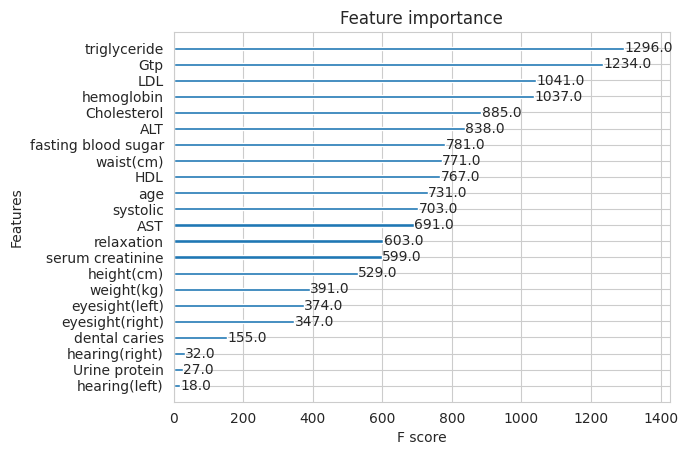

In [8]:
# plot feature importance
from matplotlib import pyplot as plt
xgb.plot_importance(model)
plt.show()